# Assignment 2 - Plant Classification

Project Name: COSC102 - Plant Classification <br>
Author: - <br>
Email: - <br>
Date: - <br>



For this project we will be looking at a dataset of plant descriptive variables that were collected at four different locations <br>
in the United states. Our task is to train a Classification Machine learning Algorithm that is able to identify which of the four <br>
locations a plant was found by using only two features from the dataset collect. We will obviously be trying to first find which <br>
two variables return the best results to use, then finding the classification algorithm that best fits the data in our dataset <br>
before finally running performance tests on our solution and coming to conclusions on our decisions and choices made throughtout <br>
the project. Without further ado... shall we!

In [4088]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import math


## Load the dataset and partition the dataset in the train and test sets

In [4091]:
# Create a function to load in csv files.

def load_dataset(csv_file_path):
    """ Takes a string of a csv's file path and converts it to a pandas dataframe.
    param: String - CSV file path.
    return Dataframe - A pandas dataframe.
    """
    return pd.read_csv(csv_file_path)

In [4093]:
# Define the file path for our data and call the load_dataset function to create our pandas object
csv_file_path = "./Plants_Dataset.csv"
plants = load_dataset(csv_file_path)

In [4095]:
# Print some basic information about our dataset
plants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Site        80 non-null     object 
 1   height      80 non-null     int64  
 2   mouth_diam  80 non-null     float64
 3   tube_diam   80 non-null     float64
 4   keel_diam   80 non-null     float64
 5   wingspread  80 non-null     int64  
 6   hoodarea    80 non-null     float64
 7   wingarea    80 non-null     float64
 8   tubearea    80 non-null     float64
 9   tubemass_g  80 non-null     float64
 10  wingmass_g  80 non-null     float64
 11  Ca_ppm      80 non-null     float64
 12  P_ppm       80 non-null     float64
 13  K_ppm       80 non-null     float64
 14  Mg_ppm      80 non-null     float64
 15  C_pct       80 non-null     float64
 16  H_pct       80 non-null     float64
 17  N_pct       80 non-null     float64
dtypes: float64(15), int64(2), object(1)
memory usage: 11.4+ KB


Our datas mostly numerical types except for "Site" which is type object, which will be a string in the abbreviated form of where the specimen was found. <br>
An important point to take note of is there is no missing values in our dataset, therefore we won't have to replace any values. Since this assignment <br>
calls for us to choose the best two performing features from the dataset and use them to plot out our results, we don't have to think too much about how <br>
to frame our data or different combinations or statistics we could use to show patterns. We just have to solve the problem that is asked, which is very <br>
straight forward and will therefore cut out alot of the thinking. So without wasting anymore precious characters..... lets split up our data and go from there.


ONE MORE THING!!!... <br>
Since we will be training a classifier to pick which site a plant was found in, and our sites are in the form of strings, we will <br>
have to convert these to some kind of number system. We will start by using the ordinal encoder to convert each value into a int <br>
since we have four different sites, this will result in each site being convert to either a 0, 1, 2, 3... shall we.

In [4098]:
# We create a subset of our dataset that only contains our site column aka our label values
sites = plants[["Site"]]

# Create our encoder
encoder = OrdinalEncoder()

# fit our encoder with our labels
sites_encoded = encoder.fit_transform(sites)

# quick check of our encoded data to make sure it worked
# sites_encoded
encoder.categories_

[array(['DG', 'HD', 'LEH', 'TJH'], dtype=object)]

In [4100]:
# Split our data into the train and test sets. Since we are training an algorithm to learn which site locations our plants are found 
# we will obviously split our x data points as all the data and our y data points as our labels which only contains our encoded sites

# x set, drop sites out, y set encoded sites
X_train, X_test, y_train, y_test = train_test_split(plants.drop("Site", axis=1), sites_encoded, random_state=42)

# Convert the pandas dataseries to numpy arrays for processing
X_train = X_train.values
X_test = X_test.values

In [4101]:
# Flatten out the y set to a 1d array so that the data can be fit for algorithm training
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [4103]:
# Create a function to scale our data. Not needed for all types of classifier traning, but no harm in running if I change the classifier
# I want to use down the line.

def scale_data(dataset):
    """
    Takes in a array and uses the sklearns built in scaler function to scale the data in the array
    param:
    Dataset - an array
    """
    scaler = StandardScaler()
    scaler.fit(dataset)

# Standardizing our X set, we will do this to our test set later
scale_data(X_train)

## Select the 2 most higher-performing features based upon cross-validation carried out on the training dataset.

In [4314]:
# Creating a method to sort through all of our features and pick the best ones to use

def feature_selection(X_value, y_value, f1, f2):
    """
    Takes in an x, y pair of pandas dataset and two integers. It uses the integers as indexes for the X set of data
    to slice and only use the features represented by those indexes. It does this by training a classifier on the
    sliced data and the y values, then claculates the f1 score and returns the model, and the f1 score.
    params: 
    X_value - a pandas dataset of the x values
    y_value - a pandas dataset of the y values
    f1 - an integer to be used for slicing
    f2 - an integer to be used for slicing
    returns:
    f - The f1 score for the trained set of x and y inputs
    clf - The trained classifier fit with the x and y values that we passed in
    """

    # Create and train our classifier
    # clf = SVC()
    # clf = SGDClassifier(random_state=42)
    
    # The suggested rule of thumb for the amount of neighbours for the knn classifier is 
    # the sqrt(K)/2 where K is the length of your training dataset.
    neighbours = 40 #round(math.sqrt(len(X_train))/2)
    clf = KNeighborsClassifier(n_neighbors=neighbours)
    clf.fit(X_train[:, [f1,f2]], y_train)

    # Calculate the predictions our model makes on n number of folds (5 for us here)
    y_train_pred = cross_val_predict(clf, X_value[:, [f1,f2]], y_value, cv=5)

    # Get a hold of the f1_score for comparison 
    f_score = f1_score(y_train, y_train_pred, average="macro")
    # print(f"features {f1, f2} have a precision {p} recall {r} and f1 score of {f}") #, round(r[0],4), round(f[0],4)
    return f_score, clf
    
    # print(type(f1))    

Two things to note on the above function: I chose f1 score as the metric for comparison as the goal was to find the best 2 overall features to train our <br>
model with. Therefore we don't care for a model with just high recall or precision we want a model that will perform the best overall, since the f1 score <br>
takes in the weighted values of both the recall and precision of the model, and doesn't favour either a high precision or high recall, I thought it to be <br>
the best candidate for comparison of our datasets features and model training. <br><br>
The second note is on the amount of neighbours used for the knn classifier, there is no real consensus on what k should be, but there are a few rules of <br>
thumb you can follow if you wish. The reason I chose what I chose was, 
1) I wanted to make a decision instead of using the default (Not a great reason I know)
2) I didn't want to get into a curve fitting war with my own mind.
3) It seemed like a sensible way to do it since it will vary on the dataset.

In [4318]:
# Set the variables we will need to distinguish which features are the best for modeling 
best_f1 = 0
best_f2 = 0
best_score = 0


# A nested for loop to interate through all combinations of feautures in our data set 
# it sends each combination to a function which will determine the most accurate 
# selection of two features to use in our model
for feature_1 in range(17):
    for feature_2 in range(17):
        # if the features are the same as one another, skip them.
        if feature_1 == feature_2:
            continue

        # Call our selection function passing in the training sets and feautures from the
        # loop, and assign it's outputs accordingly 
        returned_score, clf = feature_selection( X_train, y_train, feature_1, feature_2)

        # Control structure for determining the highest f1 scores and best trained model
        # if the score return is > the current best score, then rewrite the variables to
        # the new values
        if float(returned_score) > best_score:
            best_score = returned_score
            best_f1 = feature_1
            best_f2 = feature_2
            classifier_of_choice = clf

            # Print out a viualization of each combination that was better than the last
            print(f"First Feature: {best_f1}\tSecond Feature: {best_f2}") 


First Feature: 0	Second Feature: 1
First Feature: 0	Second Feature: 4
First Feature: 0	Second Feature: 10
First Feature: 0	Second Feature: 12
First Feature: 9	Second Feature: 15


In [4319]:
# And the winning two features were..... drum roll! 
print(f"f1's column: {plants.columns[best_f1]} | f2's column: {plants.columns[best_f2]}") 

f1's column: tubemass_g | f2's column: C_pct


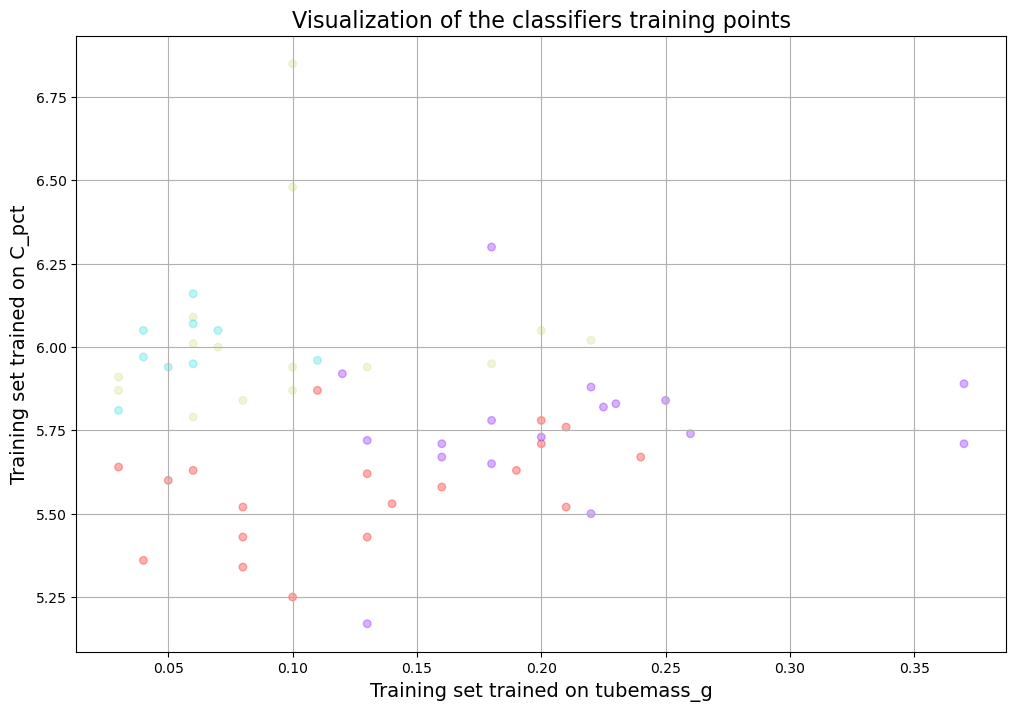

In [4320]:

# Plot out the results from our one v one cross validation of our data.
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X_train[:,best_f1], X_train[:,best_f2], c=y_train, cmap='rainbow', alpha=0.3, s=30)
ax.set_title("Visualization of the classifiers training points", fontsize=16)
ax.set_xlabel(f"Training set trained on {plants.columns[best_f1]}", fontsize=14)
ax.set_ylabel(f"Training set trained on {plants.columns[best_f2]}", rotation = 90, fontsize=14)
ax.grid()
plt.show()

Looking at the above chart it looks like we could have some interesting boundaries that have been trained

## Construct a confusion matrix based on the classifers performance on the test set and use this to calculate the recall, precision and F1 scores for each class.

In [4323]:
# Scale our test data calling our predefined scaling function
scale_data(X_test)

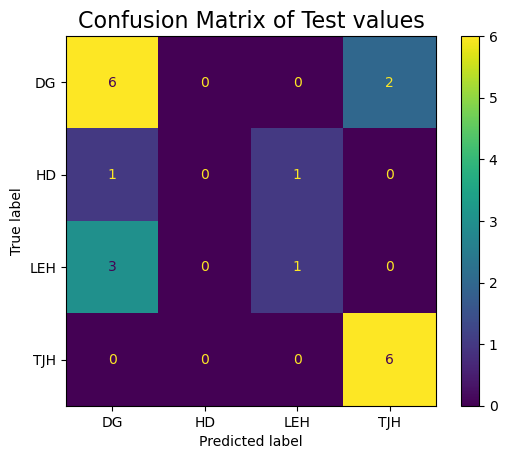

In [4324]:
# Now we predict our datasets labels and pass them into a confusion matrix with our y test values
y_test_processed = classifier_of_choice.predict(X_test[:,[best_f1, best_f2]])

# Create the confusion matrix
c = confusion_matrix(y_test, y_test_processed)

# Create a figure for our confusion matrix
fig, ax = plt.subplots()

# Create a plot to visualize our models results on the test data, passing in the encoders labels
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_processed,display_labels=encoder.categories_[0], ax=ax)

ax.set_title("Confusion Matrix of Test values", fontsize=16)
plt.show()

As we see from the bright and colourful confusion matrix above, we have trained a classifier that doesn't do <br>
too bad at all. Almost all of our values are along the center diagonal except for a large number of false positive <br>
"DG" values being misclassified as "TJH" values. That does appear to be the only achilles heal of this model. 

In [4326]:
# Displaying the precision, recall and f1 score of our test data
print(f"Test set Precision: \t{precision_score(y_test, y_test_processed, average='macro', zero_division=False)}")
print(f"Test set Recall: \t{recall_score(y_test, y_test_processed, average='macro')}")
print(f"Test set F1: \t\t{f1_score(y_test, y_test_processed, average='macro')}")

Test set Precision: 	0.4625
Test set Recall: 	0.5
Test set F1: 		0.4642857142857142


## Construct a ROC curve for each class and calculate the respective AUC values

In [4329]:
# Create a variable to hold the predicted probabilities for the test data 
y_scores = classifier_of_choice.predict_proba(X_test[:, [best_f1,best_f2]])
# y_scores = cross_val_predict(classifier_of_choice, X_test[:, [best_f1,best_f2]], y_test, cv=3, method="decision_function")
# transform our labels into a one vs all encode where the value we be 1 for the 
# correct label and 0 for all other class for each value in the test set of labels
y_test_bin = label_binarize(y_test, classes=[0.,1.,2.,3.])


Class DG Area Under Curve score: 0.7239583333333334
Class HD Area Under Curve score: 0.9166666666666667
Class LEH Area Under Curve score: 0.953125
Class TJH Area Under Curve score: 0.9166666666666667


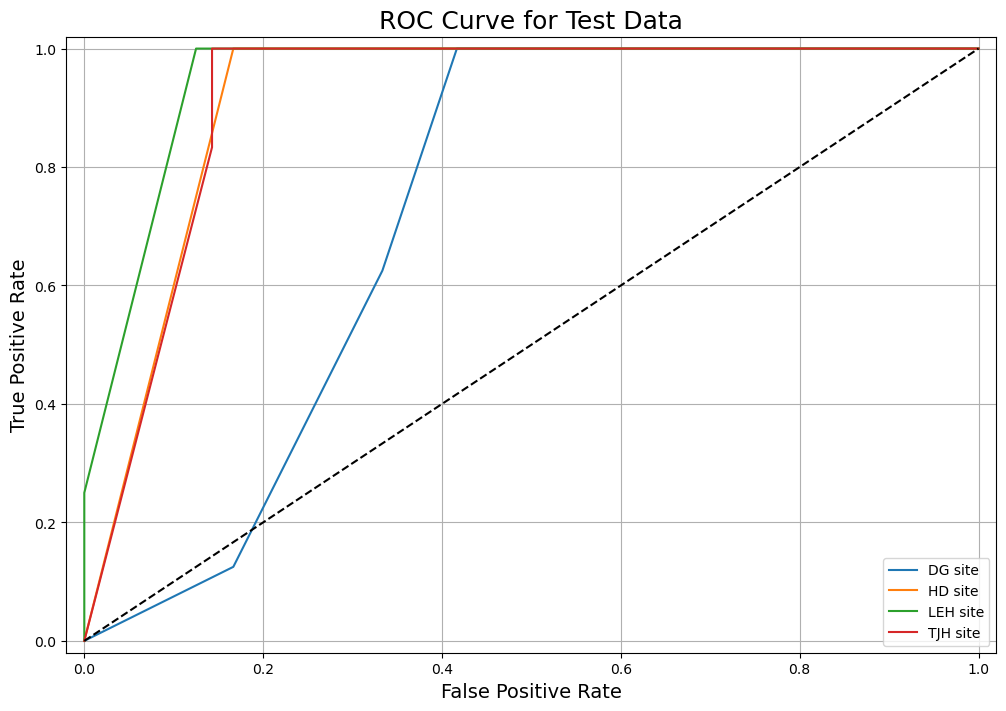

In [4330]:
# Create our figure to plot our roc curve on
fig, ax = plt.subplots(figsize=(12,8))

# Create a list of labels for our plots legend
labels = [i for i in encoder.categories_[0]]

# Iterate through the labels and plot their roc curve to the chart 
for i in range(len(labels)):
    fpr, tpr, thres = roc_curve(y_test_bin[:, i], y_scores[:, i])
    print(f"Class {labels[i]} Area Under Curve score: {roc_auc_score(y_test_bin[:, i], y_scores[:, i])}")
    plt.plot(fpr, tpr, label=labels[i] + " site")

ax.set_xlabel("False Positive Rate", fontsize=14)
ax.set_ylabel("True Positive Rate", fontsize=14, rotation=90)
ax.set_title("ROC Curve for Test Data", fontsize=18)

# Add the diagonal line and legend
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim(-0.02,1.02)
plt.ylim(-0.02,1.02)
plt.grid()
plt.legend()
plt.show()

Pretty impressive results for our classifier so far, my only regret is that there isn't more data to train and test on. <br>
The ROC Curve is more like the ROC straight and rigid line, but alas, there isn't anything we can do about our data size. <br>
Next we will move onto the final piece, the decision boundaries from our training with our test points plotted in top.

## Construct a suitable visualisation that demonstrates the decision boundaries learned by the classifer on the features selected through the cross validation process (test data aswell)

In [4333]:
# set the distance between lines in our mesh plot of boundaries, essentially it will take
# this distance of step up the plot starting from our min value to our max
h = 0.02

# Setting our min and max values of our plot, defining them from our training set values with
# our two best features.
x_min, x_max = X_train[:, best_f1].min() - 1, X_train[:, best_f1].max() + 1
y_min, y_max = X_train[:, best_f2].min() - 1, X_train[:, best_f2].max() + 1

# Create a list of coordinates for the x and y values for our decision boundaries
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Finally reshaping the predicted values from our test labels
Z = classifier_of_choice.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)


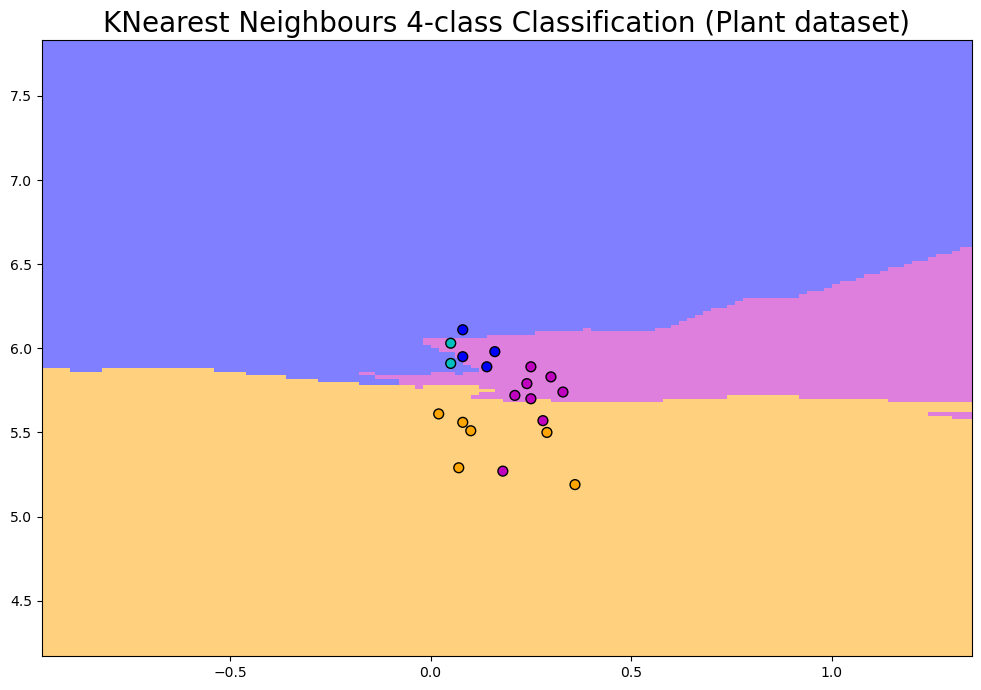

In [4334]:
# Set our colours up for our mesh and test points, they will use the same colours so you can
# see clearly where the points are and where the points should be
the_colours = ListedColormap(["m", "c", "b", "orange"])

fig, ax = plt.subplots(figsize=(12,8))

# Plot our mesh of decision boundaries
ax.pcolormesh(xx, yy, Z, cmap=the_colours, alpha=0.5)

# Optional training points plot
# ax.scatter(X_train[:, best_f1], X_train[:, best_f2], c=y_train, cmap=the_colours, edgecolor = "k", s = 20)

# Plot the test data points
ax.scatter(X_test[:, best_f1], X_test[:, best_f2], c=y_test, cmap=the_colours, edgecolor = "k", s = 50)

# Jazz up the plot
ax.set_title("KNearest Neighbours 4-class Classification (Plant dataset)", fontsize=20)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
plt.show()

The results speak for themselves, we were take a dataset given to us, process the data, select the two best features to train a classification <br>
algorithm on, and execute with prety decent results. Looking at our final chart above us here, it is clear there is still room for improvement. <br>
There is a big misclassification there and it would be interesting to know that with more data, would it get better or worse. For now this <br>
project has come to an end. I learnt alot over the 33+ hrs this took me, thank you if you are still reading this far in.

## Project Journal

The following is a log of every day I spent working on this assignment, what I was doing, thinking, etc. It is not necessary to read this... It's quite the rollercoaster of emotion.

### 27/07/24 <br>
For two days i've been trying to figure out this project, how to approach it, how to achieve a correct result.... for two days I have wasted my time. Well... wasted is abit strong, every second i spend trying something new i'm learning... be it correct or a mistake, everything is contributing at the moment. I feel very inadequate with datascience at the moment, though after reading through chapters 2 and 3, six or seven times, it's starting to make more sense in my mind. For the last few days I have been trying to create a binary classifier for a dataset that I need to make a multiclassifier for... now this isn't exactly a problem if I knew that, but I didn't so a few things really made no sense. I think i'm starting to come around to being able to fully complete this assignment now.

### 28/07/24 <br>
So I thought I had figured something out but no... i'm just an idiot. I thought I had to implement a multiclassifier, even though that makes sense to me, the criteria for the assignment doesn't want that... I have to select two features and get the precision, recall, blah blah blah... you don't do that with a multiclassifier, well atleast in my solution I didn't. I did successfully build one for this project.... very quickly too, but it's no good for the assignment, so now i'm back to square one, being very confused about what I have to do. It's not that I don't know what to do or even how to do it, it's the lack of clarity and understanding in all of this, alot seems to be taken for granted in this course at the moment, feel like im teaching myself in all honesty.

### 29/07/24 <br>
Ok here we go, so i'm coming in fresh with the mind frame of building this in such a way that it could be universal (or close enough) for any dataset you would wanna do this to. I know how to do it (I think), but it's more about implementation.

So mid session update and i'm pretty sure im doing it wrong again and I already had it right from days ago.... multiclassifier, just run precision and recall on it after it's trained, run the test data, plot it out and you are done... I think I finished this assignment already but threw it all out thinking I didn't understand.... man I don't understand anything.

### 30/07/24 <br>
Now we are focusing on finding the two best features, I think I have a solution, though my f1 scores are really low... not sure if that's a me problem, a model selection problem or it is what it is. 

Ok now im confused, I can't iterate through an SVM to find the feature two features?

My mistake, it was but a coding error... I was returning a tuple for my two f1 scores from a function, but i was unable to unpack the variables... this is because i went for dinner and came back and forgot to write that part of the code.... harmless mistake.... harmless shuts down all microsoft computers mistake... just push on commit.

Success tonight, after 12 hours in this assignment I finally feel like im on the right track, 3 of the 5 parts down and I should be able to finish the rest of it much faster then this has taken already. I feel after 5 weeks of this class, that im finally coming around to how I need to think to be able to run these note books... what do i mean by that? well, not that im able to do anything in datascience yet, but just that, like normal program, whenever im given a problem, I find it very easy to code a solution, be it some app or even a fullstack backend, frontend, database solution. But  with datascience, ive been struggling to remember that it's just python, and it's just programming, you're just thinking about what you are trying to achieve a little bit differently... anyway i'm rambling. Good session.

### 31/07/24 <br>
Ok starting today off great, realized I trained the data on a single classifier that had all the data and not trained on two of each feature at a time, meaning that my solution is.... not correct... I will now attempt to fix this...

Ok, two minutes later, I think I fixed it, but i gotta be honest.... I feel less and less confident about this project with every passing cell i press shift+enter on.... I don't know if ive done things right and I think this is going to lead to me running multiple classifiers to compare results and see just how wrong or right I am...

30 more minutes...... i've done it! and i've written a function so that I can just pass in whatever classifier I want and everything is fit, trained, tested, calculated... you name it. Still have the roc curves and plots to make, but that shouldn't be hard at all (famous last words) 

Literal famous last words, running into some high headwind at the moment, may have banged my head against the wall enough for one day already (struggling with calculus as it is). Made good progress though, I have a way to run any classifier I want on the dataset, I just need to do a bit of cleaning up and tweaking to allow any classifier without any changing of code or errors. As for roc curves... well, apparently they dont allow for multiclasses, or so it complains at me, though I know that is wrong as I know you can do it, I just gotta figure out how too... for tomorrow, roc curves, pretty plots, then big clean up, document, blah blah blah.

### 1/08/24 <br>
Ok day 6ish.. 7ish.. here we go, roc curves and maybe some plotting.

Rough start with the multi-class roc curve problem... figure my problem out, when binarizing the labels I had to declare the names of the labels and not just assign number values to each label... now we getting somewhere.

Too confident, something is wrong with everything but i cant quite figure out what it is. The knn model smashes the other two out of the water in terms of its scores, and so its auc should be higher... by alot, but it isnt, infact it's roc curves are worse and it looks like its only picking up on like 5 pieces of data..... Im unsure, gonna have to hit the google, the textbox, the tutorial and the lecture to see what I could have possibly got wrong.

mm, realizing some mistakes.... some holes... this ship is sinking... shower and refresh, approach it once more tonight from a place of cleaning and simplifing... pick up the pieces tomorrow and go again. simple.

Wow, amazing what a shower can do... I was ordering my labels incorrectly which was throwing everything majorly out of whack... came back, realized this, found a way to order them correctly and bim bop boom... roc curves all over 90 matching the other metrics and plotting correctly.... we leave it here for now. 21 hours in and still no finished product... haha and im not even optimizing as I go... oh but we will optimize... oh yes we... will.

### 2/08/24 <br>
Alright baby let's do it, I feel I can get a fully functional and working solution with all criteria met before I go to bed... LETS GO!

A brick wall... suddenly.. and with force. I have many questions to ask and problems to solve, so close, but I think I was so wrong from the beginning, or im missing one little thing to make it all come together. I can plot the decision boundaries, something Is wrong with my y_test set, first of all, it wants it converted to an array of floats... ok I can do that, but things go paired shape from there, one thing after another until the boundaries finally plot... but its just one whole colour.. I dont know.. tonight is not my night, I try again tomorrow I guess.

### 3/08/24 <br>
Ok so tonight I encode the values of the site column (which i have done before but thought I didnt need too so I undid it and preceeded to build my notebook with string values instead...) and see if that fixes everything. Luckily I built everything pretty modular so It should be as simple as retraining the test train split and... im not sure what else, im sure there will be little things... lets get into it.

Well I got it all to work... but it's all wrong... unless it's supposed to be terrible... I doubt it, so i've made mistakes during training.... I don't know how much more time i can spent on this, im almost at 30hrs... on one assignment.

its done... i had merely forgot that I changed the name of the variable of my classifier, therfore the mesh was boundaries was being trained on a completely unrelated variable that just happened to work for the mesh... hah, the downside of using jyupter... no linting or debugging tools really.... you gotta really investigate or change up the way you code as to avoid this kind of mistake. 

### 4/08/24 <br>
Looking to finish this today, lots of annotating and writing to do, and than the video!

No report or video done, but the notebook completely finished and commented. The report is technically written as I leave large paragraph throughout the noteboook, so just compiling those thoughts into some more.... digestable. That was a journey... a real god damn journey. Very happy i'm at the end and have a working solution, though I know there is alot more I can do, alot more little things ive read in the textbook that would improve the outcome, not to mention I wanted to make it run tests for every classifier... it seemed out of scope for the assignment, so it will have to be a project for another time.